In [4]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
import geocoder
import os
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

Libraries imported.


In [4]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [5]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'ME40SJAYZMUJZZLXLSVENPEMVUJNV2NHYCJQW4NWYOUYYILP' # your Foursquare ID
    CLIENT_SECRET = 'RJAWTE4ZIWPSJRM21A1ECC15JU1IAQOCTHL1T0XTFLQGNMKW' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [6]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'ME40SJAYZMUJZZLXLSVENPEMVUJNV2NHYCJQW4NWYOUYYILP' # your Foursquare ID
    CLIENT_SECRET = 'RJAWTE4ZIWPSJRM21A1ECC15JU1IAQOCTHL1T0XTFLQGNMKW' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [7]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [8]:
new_york_data=get_new_york_data()

In [47]:
new_york_data = pd.read_csv('data sets\\new_york_data.csv')
middle_eastern_ny_rest = pd.read_csv('data sets\\middle_eastern_ny_rest.csv')
middle_eastern_rest_stats_ny = pd.read_csv('data sets\\middle_eastern_rest_stats_ny.csv')

In [7]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [10]:
new_york_data.shape

(306, 4)

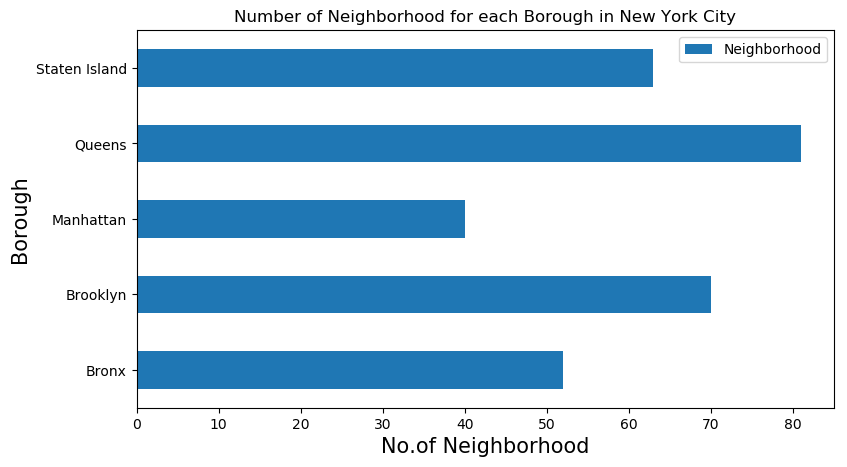

In [9]:

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('No.of Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('Borough', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='barh')
#legend
plt.legend()
#displays the plot
plt.show()

In [ ]:
# prepare neighborhood list that contains middle eastern resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
middle_eastern_ny_rest=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    middle_eastern_resturants=venues[venues['Category']=='Middle Eastern Restaurant']   
    print('(',count,'/',len(new_york_data),')','Middle Eastern Resturants in '+Neighborhood+', '+Borough+':'+str(len(middle_eastern_resturants)))
    for resturant_detail in middle_eastern_resturants.values.tolist():
        id, name , category=resturant_detail
        middle_eastern_ny_rest = middle_eastern_ny_rest.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

In [10]:
middle_eastern_ny_rest.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Morris Heights,4b298f71f964a520eba024e3,Golan Heights
1,Brooklyn,Bay Ridge,4b6785d6f964a520aa532be3,Karam
2,Brooklyn,Bay Ridge,58bee70d5804ea784f84ad53,Ruzana
3,Brooklyn,Manhattan Terrace,4cd2f57125ee6dcb7054470f,Aksaray Gyro
4,Brooklyn,Flatbush,4d90d33b5091a1cdf601c401,Gyro King


In [11]:
middle_eastern_ny_rest.shape

(69, 4)

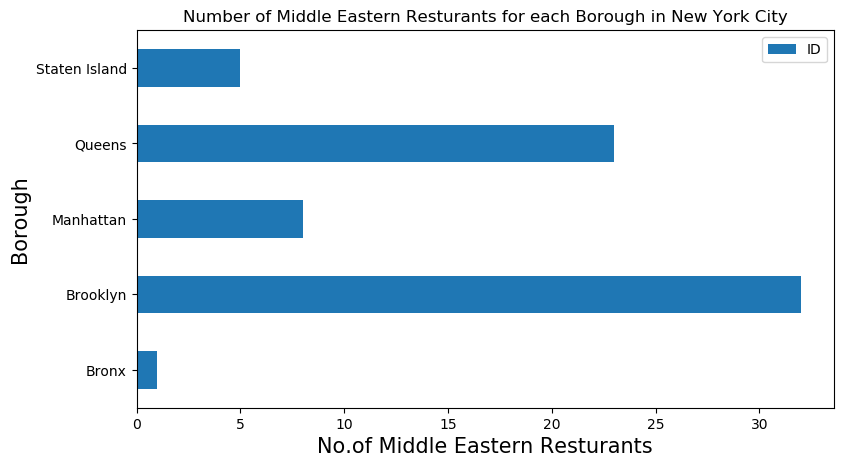

In [13]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Middle Eastern Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('No.of Middle Eastern Resturants', fontsize = 15)
#On y-axis
plt.ylabel('Borough', fontsize=15)
#giving a bar plot
middle_eastern_ny_rest.groupby('Borough')['ID'].count().plot(kind='barh')
#legend
plt.legend()
#displays the plot
plt.show()

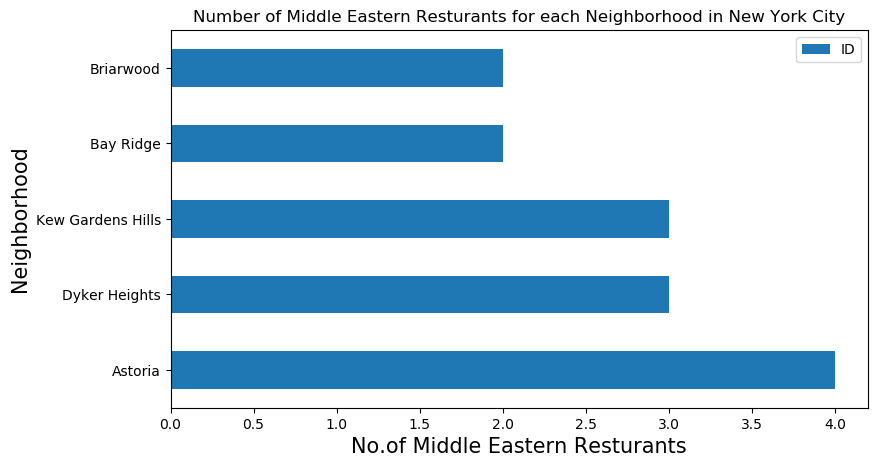

In [15]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Middle Eastern Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('No.of Middle Eastern Resturants', fontsize = 15)
#On y-axis
plt.ylabel('Neighborhood', fontsize=15)
#giving a bar plot
middle_eastern_ny_rest.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='barh')
#legend
plt.legend()
#displays the plot
plt.show()

In [45]:
middle_eastern_ny_rest[middle_eastern_ny_rest['Neighborhood']=='Astoria']

,Borough,Neighborhood,ID,Name
36,Queens,Astoria,4ba58abaf964a520d01039e3,Al-sham Sweets and Pastries
37,Queens,Astoria,578837cecd108caad4364993,King of Falafel and Shawarma
38,Queens,Astoria,4276bf00f964a5208e211fe3,Mombar
39,Queens,Astoria,4b726a56f964a520467a2de3,Halal Sandwich Shop


In [ ]:
# prepare neighborhood list that contains middle eastern resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
middle_eastern_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in middle_eastern_ny_rest.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(middle_eastern_ny_rest),')','processed')
    middle_eastern_rest_stats_ny = middle_eastern_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

In [55]:
middle_eastern_rest_stats_ny.shape

(50, 7)

In [56]:
middle_eastern_ny_rest.shape

(69, 4)

In [57]:
middle_eastern_rest_stats_ny.to_csv('middle_eastern_rest_stats_ny.csv', index=False)

In [49]:
middle_eastern_rest_stats_ny_csv=pd.read_csv('middle_eastern_rest_stats_ny.csv')

In [50]:
middle_eastern_rest_stats_ny_csv.shape

(50, 7)

In [51]:
middle_eastern_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Morris Heights,4b298f71f964a520eba024e3,Golan Heights,20,7.8,10
1,Brooklyn,Bay Ridge,4b6785d6f964a520aa532be3,Karam,66,8.8,36
2,Brooklyn,Bay Ridge,58bee70d5804ea784f84ad53,Ruzana,9,7.7,4
3,Brooklyn,Manhattan Terrace,4cd2f57125ee6dcb7054470f,Aksaray Gyro,12,7.3,1
4,Brooklyn,Flatbush,4d90d33b5091a1cdf601c401,Gyro King,12,7.7,6


In [61]:
middle_eastern_rest_stats_ny_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
Borough         50 non-null object
Neighborhood    50 non-null object
ID              50 non-null object
Name            50 non-null object
Likes           50 non-null int64
Rating          50 non-null float64
Tips            50 non-null int64
dtypes: float64(1), int64(2), object(4)
memory usage: 2.8+ KB


In [62]:
middle_eastern_rest_stats_ny['Likes']=middle_eastern_rest_stats_ny['Likes'].astype('float64')

In [63]:
middle_eastern_rest_stats_ny['Tips']=middle_eastern_rest_stats_ny['Tips'].astype('float64')

In [64]:
middle_eastern_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
Borough         50 non-null object
Neighborhood    50 non-null object
ID              50 non-null object
Name            50 non-null object
Likes           50 non-null float64
Rating          50 non-null float64
Tips            50 non-null float64
dtypes: float64(3), object(4)
memory usage: 2.8+ KB


In [65]:
middle_eastern_rest_stats_ny.iloc[middle_eastern_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood           Greenwich Village
ID              45a7dc66f964a52019411fe3
Name                           12 Chairs
Likes                                411
Rating                               9.1
Tips                                 132
Name: 34, dtype: object

In [66]:
middle_eastern_rest_stats_ny.iloc[middle_eastern_rest_stats_ny['Rating'].idxmax()]

Borough                         Brooklyn
Neighborhood            Brooklyn Heights
ID              43eb685af964a520382f1fe3
Name                          Yemen Cafe
Likes                                324
Rating                               9.1
Tips                                  95
Name: 11, dtype: object

In [67]:
middle_eastern_rest_stats_ny.iloc[middle_eastern_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood           Greenwich Village
ID              45a7dc66f964a52019411fe3
Name                           12 Chairs
Likes                                411
Rating                               9.1
Tips                                 132
Name: 34, dtype: object

In [73]:
ny_neighborhood_stats=middle_eastern_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']


In [30]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
13,Greenwich Village,9.10
2,Boerum Hill,8.90
3,Brooklyn Heights,8.65
6,Cobble Hill,8.65
8,Downtown,8.45
24,Prospect Park South,8.40
21,Morningside Heights,8.40
30,Windsor Terrace,8.30
26,Sunnyside,8.30
1,Bay Ridge,8.25


In [71]:

ny_borough_stats=middle_eastern_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']


In [68]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.257143
0,Bronx,7.800000
1,Brooklyn,7.746429
3,Queens,7.607143


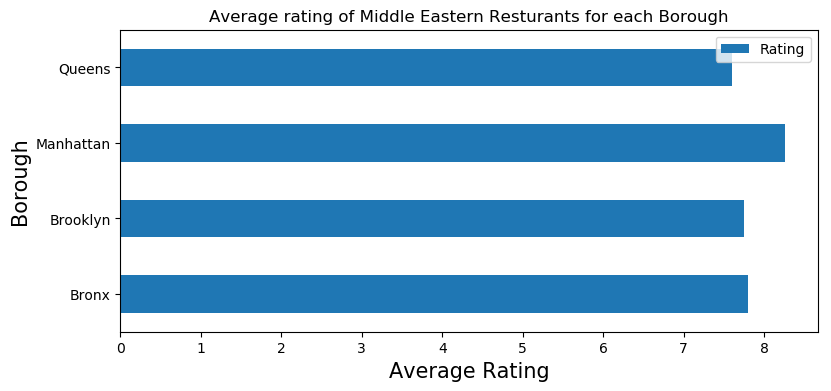

In [33]:
plt.figure(figsize=(9,4), dpi = 100)
# title
plt.title('Average rating of Middle Eastern Resturants for each Borough')
#On x-axis
plt.xlabel('Average Rating', fontsize = 15)
#On y-axis
plt.ylabel('Borough', fontsize=15)
#giving a bar plot
middle_eastern_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='barh')
#legend
plt.legend(loc='upper right')
#displays the plot
plt.show()

In [34]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]

In [81]:
ny_neighborhood_stats.head()

,Neighborhood,Average Rating,Borough_x,Latitude_x,Longitude_x,Borough_y,Latitude_y,Longitude_y
0,Astoria,8.00,Queens,40.768509,-73.915654,Queens,40.768509,-73.915654
1,Bay Ridge,8.25,Brooklyn,40.625801,-74.030621,Brooklyn,40.625801,-74.030621
2,Boerum Hill,8.90,Brooklyn,40.685683,-73.983748,Brooklyn,40.685683,-73.983748
3,Brooklyn Heights,8.65,Brooklyn,40.695864,-73.993782,Brooklyn,40.695864,-73.993782
4,Central Harlem,8.10,Manhattan,40.815976,-73.943211,Manhattan,40.815976,-73.943211


In [82]:
ny_neighborhood_stats.shape

(34, 8)

In [83]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [84]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [86]:
ny_neighborhood_stats.head()

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Queens,Astoria,40.768509,-73.915654,8.00
1,Brooklyn,Bay Ridge,40.625801,-74.030621,8.25
2,Brooklyn,Boerum Hill,40.685683,-73.983748,8.90
3,Brooklyn,Brooklyn Heights,40.695864,-73.993782,8.65
4,Manhattan,Central Harlem,40.815976,-73.943211,8.10


In [38]:
ny_neighborhood_stats.shape

(17, 5)

In [77]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [78]:

# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [79]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [80]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

In [81]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = 'Borough Boundaries.geojson'

ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)

# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')